In [198]:
import pandas as pd
import numpy as np 
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Creating datasets

In [199]:
# # BELOW IS RAW DAILY DATA
# all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\daily_deaths.csv")
# all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

# all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\daily_infections.csv")
# all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

# deaths = all_county_deaths.rename(columns={'confirmed': 'Deaths'})
# infected = all_county_infected.rename(columns={'confirmed': 'Infected'})

# merged_df = pd.merge(infected, deaths, on='date', how='outer')

In [200]:
# BELOW IS RAW WEEKLY DATA
all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\weekly_deaths.csv")
all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\weekly_infections.csv")
all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

deaths = all_county_deaths.rename(columns={'confirmed': 'Deaths'})
infected = all_county_infected.rename(columns={'confirmed': 'Infected'})

merged_df = pd.merge(infected, deaths, on='date', how='outer')

In [201]:
# # BELOW IS 7 day rolling
# all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\daily_deaths.csv")
# all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

# all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\7_day_rolling_infections.csv")
# all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

# deaths = all_county_deaths.rename(columns={'confirmed': 'Deaths'})
# infected = all_county_infected.rename(columns={'confirmed': 'Infected'})

# merged_df = pd.merge(infected, deaths, on='date', how='outer')

In [202]:
all_county_exemption_rates = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used - OLD\exemption_rates.xlsx")
all_county_population = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used - OLD\county_size_N.xlsx")

In [203]:
efficacy = 0.95 # measles vaccine efficacy (average of cdc stats for 1 and 2 doses)
county_name = 'Texas'

deaths = all_county_deaths.set_index('date')
infected = all_county_infected.set_index('date')

exemption = all_county_exemption_rates[all_county_exemption_rates['County'] == county_name]
exemption_val = float(exemption['Exemption Rate'].values[0])

population = all_county_population[all_county_population['County'] == county_name]
pop_val = int(population['Population'].values[0])

# calculate population N to make closed system S + I + R + D = N
N = pop_val*(1-(1-exemption_val)*efficacy)
# N = pop_val
print(N)


2272222.654181933


In [66]:
# # merged_df = pd.concat([infected.rename("Infected"),
# #                        deaths.rename("Deaths")], axis=1)

# # merged_df = merged_df.reset_index().rename(columns={'index': 'Date'})
# merged_df = pd.merge(infected, deaths, on='date', how='outer')

# print(merged_df.head())

# UNRESTRICTED GREEKS

In [ ]:
H = np.array([
    [0, 1, 0],  # I
    [0, 0, 1]   # D
])

n_ens = 500
dt = 1.0

alpha = 1.2
tol = 1e-3
ens_perturb = 0.6

beta_low, beta_high = 0, 1e6
gamma_low, gamma_high = 0.05, 0.2 # recovery rate 
delta_low, delta_high = 0, 0.001

In [ ]:
# Initialize from data: only Infected and Deaths
I0 = int(merged_df['Infected'].iloc[0])
D0 = int(merged_df['Deaths'].iloc[0])
S0 = max(N - I0 - D0, 0)

# Hidden state mean vector
x0_mean = np.array([S0, I0, D0])

def R_from_obs(y_obs_k):
    # Replace nan with small positive value
    y_safe = np.where(np.isnan(y_obs_k), 0.01, y_obs_k)
    std_devs = 0.3 * np.maximum(y_safe, 0.03)
    cov_matrix = np.diag(std_devs ** 2)
    cov_matrix += np.eye(len(y_obs_k)) * 1e-6
    return cov_matrix

def enforce_mass(state_ens, N):
    np.maximum(state_ens, 0.0, out=state_ens)
    total_IRD = state_ens[:, 1] + state_ens[:, 2]
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:3] *= scale
        state_ens[over, 0] = 0.0
    return state_ens

def sird_step(state, N, day, dt):    
    S, I, D, beta, gamma, delta = state
    # effective_beta = beta * (1 - ((1-exemption_val) * efficacy))
    dS = - beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dD = delta * I
    S_new = max(S + dS * dt, 0)
    I_new = max(I + dI * dt, 0)
    D_new = max(D + dD * dt, 0)
    
    beta_new = beta + np.random.normal(0, 0.5)
    gamma_new = gamma + np.random.normal(0, 0.5)
    delta_new = delta + np.random.normal(0, 0.5)
    return np.array([S_new, I_new, D_new, beta_new, gamma_new, delta_new])

def predict_measurement(state_ensemble):
    return state_ensemble[:, 1:3]

def clean_nans(actual, predicted):
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    return actual[mask], predicted[mask]

In [69]:
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

def run_enkf_for_seed(sim_seed):
    rng = np.random.default_rng(sim_seed)

    def u(lo, hi, size):    
        return rng.uniform(lo, hi, size)

    # Initialize ensemble states with perturbations around [S, I, D]
    state_ens = np.zeros((n_ens, 6))
    for i in range(n_ens):
        perturb = 1 + ens_perturb * rng.normal(size=2)
        ID = np.maximum(x0_mean[1:] * perturb, 0)
        S = max(N - ID.sum(), 0)
        beta = rng.uniform(beta_low, beta_high)
        gamma = rng.uniform(gamma_low, gamma_high)
        delta = rng.uniform(delta_low, delta_high)
        state_ens[i] = np.array([S, ID[0], ID[1], beta, gamma, delta])
        
    state_ens[:, 1] += I0

    n_timesteps = len(merged_df)
    ensemble_states_hist = np.full((n_timesteps, n_ens, 6), np.nan)

    max_passes = 10
    pass_idx = 0
    total_cycles = 0
    converged = False
    converged_day = None
    converg_counter = 0

    # Observations: only Infected and Deaths
    Y_obs = merged_df[['Infected', 'Deaths']].to_numpy()

    while pass_idx < max_passes and not converged:
        pass_idx += 1

        # Optional re-initialization each pass
        for i in range(n_ens):
            perturb = 1 + ens_perturb * rng.normal(size=2)
            ID = np.maximum(x0_mean[1:] * perturb, 0)
            S = max(N - ID.sum(), 0)
            beta = rng.uniform(beta_low, beta_high)
            gamma = rng.uniform(gamma_low, gamma_high)
            delta = rng.uniform(delta_low, delta_high)
            state_ens[i] = np.array([S, ID[0], ID[1], beta, gamma, delta])
        state_ens = enforce_mass(state_ens, N)

        converged_day = None

        for k in range(n_timesteps):
            total_cycles += 1

            # Forecast step
            for i in range(n_ens):
                state_ens[i] = sird_step(state_ens[i], N, k, dt)
            state_ens = enforce_mass(state_ens, N)

            ensemble_states_hist[k] = state_ens.copy()

            # Measurement prediction
            meas_pred = predict_measurement(state_ens)  # shape (n_ens, 2)
            y_obs_k = Y_obs[k]
            y_obs_k = np.nan_to_num(y_obs_k, nan=1e-2)
            Rk = R_from_obs(y_obs_k)
            obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

            # Kalman update
            aug_ens = state_ens.copy()  # shape (n_ens, 6)
            aug_mean = np.mean(aug_ens, axis=0)
            meas_mean = np.mean(meas_pred, axis=0)

            X = aug_ens - aug_mean
            Y = meas_pred - meas_mean
            C_xy = (X.T @ Y) / (n_ens - 1)
            C_yy = (Y.T @ Y) / (n_ens - 1)

            Kk = C_xy @ np.linalg.inv(C_yy + Rk)

            for i in range(n_ens):
                innovation = obs_perturbed[i] - meas_pred[i]
                aug_update = aug_ens[i] + alpha * (Kk @ innovation)
                state_ens[i] = aug_update
            state_ens = enforce_mass(state_ens, N)

            ensemble_states_hist[k] = state_ens.copy()
            
            # Print key diagnostics
            print(f"Day {k}: I mean = {np.mean(state_ens[:,1]):.2f}, I std = {np.std(state_ens[:,1]):.2f}, True I = {Y_obs[k,0]:.2f}")


            # Check convergence
            if k > 0:
                prev_mean_theta = np.mean(ensemble_states_hist[k - 1, :, 3:6], axis=0)
                curr_mean_theta = np.mean(state_ens[:, 3:6], axis=0)
                rel_change = np.linalg.norm(curr_mean_theta - prev_mean_theta, ord=np.inf) / (np.linalg.norm(prev_mean_theta) + 1e-9)
                if rel_change < tol:
                    converg_counter += 1
                    if converg_counter >= 1:
                        converged_day = k
                else:
                    converg_counter = 0

        last_day = converged_day if converged_day is not None else n_timesteps - 1
        mean_states = np.nanmean(ensemble_states_hist[: last_day + 1], axis=1)

        if converged_day is not None:
            converged = True

    # Metrics
    actual_I = Y_obs[: last_day + 1, 0]
    actual_D = Y_obs[: last_day + 1, 1]
    pred_I = mean_states[:, 1]
    pred_D = mean_states[:, 2]

    actual_I, pred_I = clean_nans(actual_I, pred_I)
    actual_D, pred_D = clean_nans(actual_D, pred_D)

    rmse_I = np.sqrt(root_mean_squared_error(actual_I, pred_I))
    r2_I = r2_score(actual_I, pred_I)
    rmse_D = np.sqrt(root_mean_squared_error(actual_D, pred_D))
    r2_D = r2_score(actual_D, pred_D)

    return {
        'rmse_I': rmse_I,
        'r2_I': r2_I,
        'rmse_D': rmse_D,
        'r2_D': r2_D,
        'total_cycles': total_cycles,
        'converged_day': converged_day,
        'mean_states': mean_states
    }

In [70]:
seeds = 11  # Adjust as needed

results = []
# for seed in seeds:
#     res = run_enkf_for_seed(seed)
#     results.append(res)

res = run_enkf_for_seed(seeds)
results.append(res)

# Extract metrics
total_cycles_list = [r['total_cycles'] for r in results]
rmse_I_list = [r['rmse_I'] for r in results]
r2_I_list = [r['r2_I'] for r in results]
rmse_D_list = [r['rmse_D'] for r in results]
r2_D_list = [r['r2_D'] for r in results]

print(f"Mean assimilation cycles: {np.mean(total_cycles_list):.2f} ± {np.std(total_cycles_list):.2f}")
print("Infected (I):   RMSE {:.2f} ± {:.2f} | R² {:.4f} ± {:.4f}".format(np.mean(rmse_I_list), np.std(rmse_I_list), np.mean(r2_I_list), np.std(r2_I_list)))
print("Deceased (D):   RMSE {:.2f} ± {:.2f} | R² {:.4f} ± {:.4f}".format(np.mean(rmse_D_list), np.std(rmse_D_list), np.mean(r2_D_list), np.std(r2_D_list)))

Day 0: I mean = 8.21, I std = 1.79, True I = 9.00
Day 1: I mean = 20.81, I std = 2.22, True I = 20.00
Day 2: I mean = 26.07, I std = 3.85, True I = 27.00
Day 3: I mean = 52.61, I std = 5.59, True I = 50.00
Day 4: I mean = 66.72, I std = 9.25, True I = 68.00
Day 5: I mean = 57.48, I std = 10.49, True I = 60.00
Day 6: I mean = 71.91, I std = 9.82, True I = 68.00
Day 7: I mean = 64.41, I std = 12.01, True I = 65.00
Day 8: I mean = 85.83, I std = 11.11, True I = 80.00
Day 9: I mean = 62.80, I std = 13.88, True I = 67.00
Day 10: I mean = 70.24, I std = 10.27, True I = 66.00
Day 11: I mean = 50.98, I std = 10.43, True I = 53.00
Day 12: I mean = 44.78, I std = 7.67, True I = 43.00
Day 13: I mean = 20.25, I std = 6.25, True I = 22.00
Day 14: I mean = 21.73, I std = 3.11, True I = 20.00
Day 15: I mean = 7.01, I std = 3.20, True I = 9.00
Day 16: I mean = 7.75, I std = 1.04, True I = 7.00
Day 17: I mean = 10.68, I std = 1.52, True I = 10.00
Day 18: I mean = 1.55, I std = 1.26, True I = 3.00
Day 1

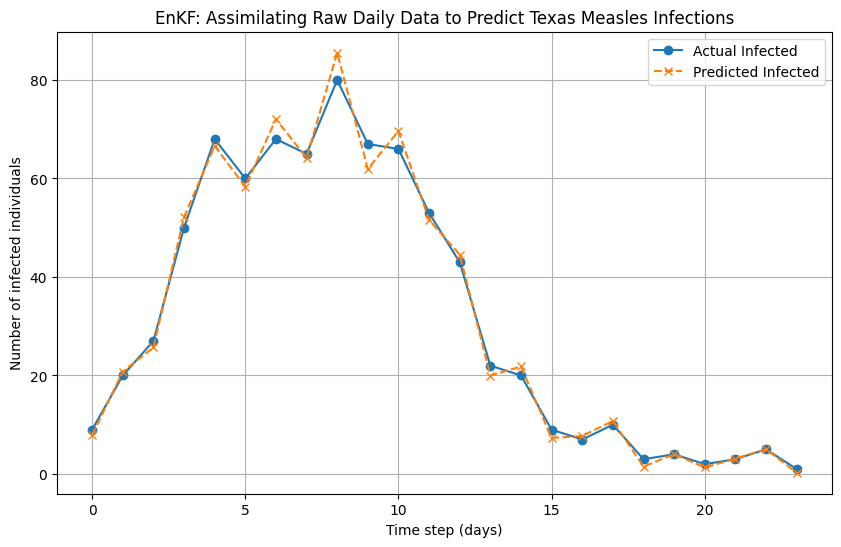

In [71]:
import matplotlib.pyplot as plt

mean_states = results[0]['mean_states']
pred_R = mean_states[:, 1]
actual_R = merged_df['Infected'].values[:len(pred_R)]

plt.figure(figsize=(10, 6))
plt.plot(actual_R, label='Actual Infected', linestyle='-', marker='o')
plt.plot(pred_R, label='Predicted Infected', linestyle='--', marker='x')
plt.xlabel('Time step (days)')
plt.ylabel('Number of infected individuals')
plt.title('EnKF: Assimilating Raw Daily Data to Predict Texas Measles Infections')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
# import pandas as pd

# # After running your EnKF and getting predictions & dates
# dates = merged_df['date'][:len(results[0]['mean_states'])]  # get dates matching mean_states length
# predicted_infected = results[0]['mean_states'][:, 1]        # assuming infected is at idx 1
# true_infected = merged_df['Infected'][:len(predicted_infected)].to_numpy()

# # Create DataFrame
# df_save = pd.DataFrame({
#     'date': dates,
#     'EnKF Infected': predicted_infected,
#     'true_infected': true_infected
# })

# # Save to CSV (use raw string for windows paths)
# csv_path = r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\combined graphs\weekly.csv"
# df_save.to_csv(csv_path, index=False)


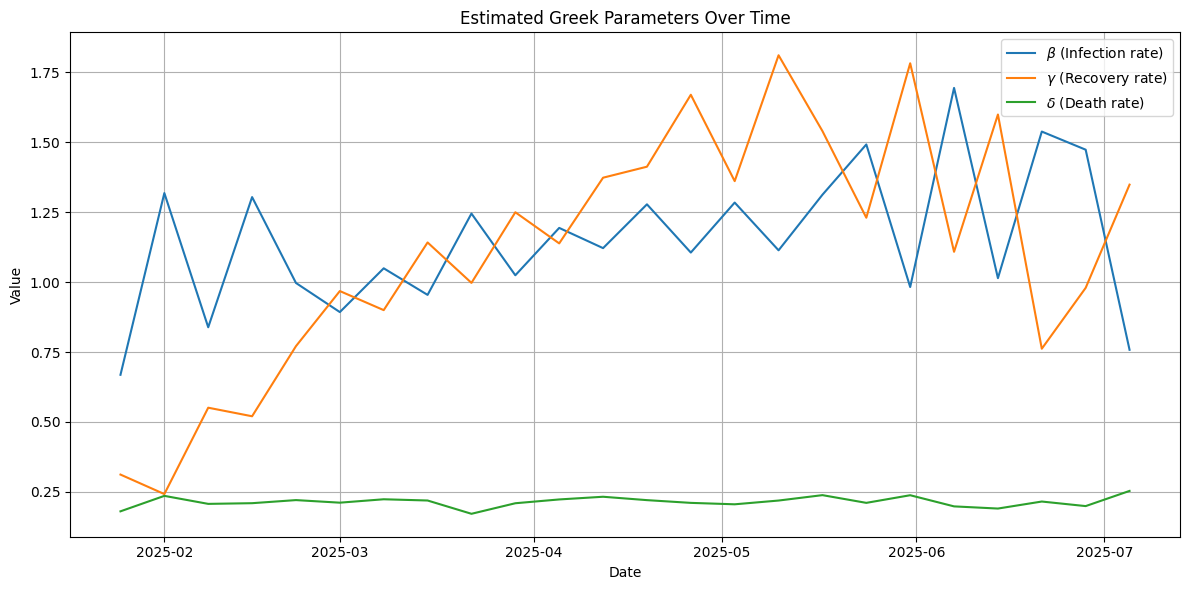

In [73]:
import matplotlib.pyplot as plt

def plot_greek_parameters_over_time(mean_states, dates):
    # mean_states shape is (n_timesteps, 6) with columns [S, I, D, beta, gamma, delta]
    beta = mean_states[:, 3]
    gamma = mean_states[:, 4]
    delta = mean_states[:, 5]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, beta, label=r'$\beta$ (Infection rate)')
    plt.plot(dates, gamma, label=r'$\gamma$ (Recovery rate)')
    plt.plot(dates, delta, label=r'$\delta$ (Death rate)')

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Estimated Greek Parameters Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage after your EnKF run for seed 10:
mean_states = results[0]['mean_states']
dates = merged_df['date'][:mean_states.shape[0]]

plot_greek_parameters_over_time(mean_states, dates)


# RESTRICTING GREEKS

In [228]:
# in clipping justchange upper bound to np.inf to unrestrict otherewise greek_hihg
H = np.array([
    [0, 1, 0],  # I
    [0, 0, 1]   # D
])

n_ens = 500
dt = 1.0

alpha = 1.2
tol = 1e-3
ens_perturb = 0.4

beta_low, beta_high = 0, 0.6
gamma_low, gamma_high = 0, 0.5 # recovery rate 
delta_low, delta_high = 0, 0.01

# 0.2, 0.5, 0.01

# gamma = 0.15 # recovery rate 
# delta = 0.002

In [229]:
import numpy as np

# Initial states from observed data
I0 = int(merged_df['Infected'].iloc[0])
D0 = int(merged_df['Deaths'].iloc[0])
S0 = max(N - I0 - D0, 0)

x0_mean = np.array([S0, I0, D0])

def R_from_obs(y_obs_k):
    y_safe = np.where(np.isnan(y_obs_k), 0.03, y_obs_k)
    # floor at 0.03 so zeros still get some noise
    std_devs = 0.3 * np.maximum(y_safe, 0.03)
    cov_matrix = np.diag(std_devs ** 2)
    cov_matrix += np.eye(len(y_obs_k)) * 1e-6
    return cov_matrix

def enforce_mass(state_ens, N):
    np.maximum(state_ens, 0.0, out=state_ens)
    total_IRD = state_ens[:, 1] + state_ens[:, 2]
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:3] *= scale
        state_ens[over, 0] = 0.0
    return state_ens

def sird_step(state, N, day, dt):    
    S, I, D, beta, gamma, delta = state

    # SIRD dynamics
    dS = - beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dD = delta * I

    S_new = max(S + dS * dt, 0.0)
    I_new = max(I + dI * dt, 0.0)
    D_new = max(D + dD * dt, 0.0)

    # Random walks for parameters, only enforce non-negativity
    # beta_new  = np.clip(beta  + np.random.normal(0, 0.1),   0.0)
    beta_new = np.clip(beta + np.random.normal(0, 0.1), 0.0, 1)
    gamma_new = np.clip(gamma + np.random.normal(0, 0.05),  0.0, 1)
    delta_new = np.clip(delta + np.random.normal(0, 0.001), 0.0, delta_high)
    
    return np.array([S_new, I_new, D_new, beta_new, gamma_new, delta_new])

def predict_measurement(state_ensemble):
    # Predicted I and D from each ensemble member
    return state_ensemble[:, 1:3]

def clean_nans(actual, predicted):
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    return actual[mask], predicted[mask]

In [230]:
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

def run_enkf_for_seed(sim_seed):
    rng = np.random.default_rng(sim_seed)

    def u(lo, hi, size):    
        return rng.uniform(lo, hi, size)

    # Initialize ensemble states
    state_ens = np.zeros((n_ens, 6))
    for i in range(n_ens):
        perturb = 1 + ens_perturb * rng.normal(size=2)
        ID = np.maximum(x0_mean[1:] * perturb, 0)
        S = max(N - ID.sum(), 0)
        beta = rng.uniform(beta_low, beta_high)
        gamma = rng.uniform(gamma_low, gamma_high)
        delta = rng.uniform(delta_low, delta_high)
        state_ens[i] = np.array([S, ID[0], ID[1], beta, gamma, delta])
        
    state_ens[:, 1] += I0

    n_timesteps = len(merged_df)
    ensemble_states_hist = np.full((n_timesteps, n_ens, 6), np.nan)
    max_passes = 10
    pass_idx = 0
    total_cycles = 0
    converged = False
    converged_day = None
    converg_counter = 0

    # Observations
    Y_obs = merged_df[['Infected', 'Deaths']].to_numpy()

    while pass_idx < max_passes and not converged:
        pass_idx += 1
        # Optional re-initialization
        for i in range(n_ens):
            perturb = 1 + ens_perturb * rng.normal(size=2)
            ID = np.maximum(x0_mean[1:] * perturb, 0)
            S = max(N - ID.sum(), 0)
            beta = rng.uniform(beta_low, beta_high)
            gamma = rng.uniform(gamma_low, gamma_high)
            delta = rng.uniform(delta_low, delta_high)
            state_ens[i] = np.array([S, ID[0], ID[1], beta, gamma, delta])
        state_ens = enforce_mass(state_ens, N)

        converged_day = None

        for k in range(n_timesteps):
            total_cycles += 1

            # Forecast step
            for i in range(n_ens):
                state_ens[i] = sird_step(state_ens[i], N, k, dt)
            state_ens = enforce_mass(state_ens, N)

            ensemble_states_hist[k] = state_ens.copy()

            # Measurement prediction
            meas_pred = predict_measurement(state_ens)
            y_obs_k = Y_obs[k]
            y_obs_k = np.nan_to_num(y_obs_k, nan=1e-2)
            Rk = R_from_obs(y_obs_k)

            # inject noise into observed I,D for each ensemble member
            obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

            # Kalman update
            aug_ens = state_ens.copy()
            aug_mean = np.mean(aug_ens, axis=0)
            meas_mean = np.mean(meas_pred, axis=0)
            X = aug_ens - aug_mean
            Y = meas_pred - meas_mean
            C_xy = (X.T @ Y) / (n_ens - 1)
            C_yy = (Y.T @ Y) / (n_ens - 1)
            Kk = C_xy @ np.linalg.inv(C_yy + Rk)

            for i in range(n_ens):
                innovation = obs_perturbed[i] - meas_pred[i]
                aug_update = aug_ens[i] + alpha * (Kk @ innovation)
                # rely on sird_step / enforce_mass for any parameter bounding
                state_ens[i] = aug_update

            state_ens = enforce_mass(state_ens, N)
            ensemble_states_hist[k] = state_ens.copy()

            print(f"Day {k}: I mean = {np.mean(state_ens[:,1]):.2f}, "
                  f"I std = {np.std(state_ens[:,1]):.2f}, "
                  f"True I = {Y_obs[k,0]:.2f}")

            # Convergence check
            if k > 0:
                prev_mean_theta = np.mean(ensemble_states_hist[k - 1, :, 3:6], axis=0)
                curr_mean_theta = np.mean(state_ens[:, 3:6], axis=0)
                rel_change = (
                    np.linalg.norm(curr_mean_theta - prev_mean_theta, ord=np.inf) /
                    (np.linalg.norm(prev_mean_theta) + 1e-9)
                )
                if rel_change < tol:
                    converg_counter += 1
                    if converg_counter >= 1:
                        converged_day = k
                else:
                    converg_counter = 0

        mean_states = np.nanmean(ensemble_states_hist, axis=1)

        if converged_day is not None:
            converged = True

    # Metrics
    actual_I = Y_obs[:, 0]
    actual_D = Y_obs[:, 1]
    pred_I = mean_states[:, 1]
    pred_D = mean_states[:, 2]

    actual_I, pred_I = clean_nans(actual_I, pred_I)
    actual_D, pred_D = clean_nans(actual_D, pred_D)

    rmse_I = np.sqrt(root_mean_squared_error(actual_I, pred_I))
    r2_I = r2_score(actual_I, pred_I)
    rmse_D = np.sqrt(root_mean_squared_error(actual_D, pred_D))
    r2_D = r2_score(actual_D, pred_D)

    return {
        'rmse_I': rmse_I,
        'r2_I': r2_I,
        'rmse_D': rmse_D,
        'r2_D': r2_D,
        'total_cycles': total_cycles,
        'converged_day': converged_day,
        'mean_states': mean_states
    }

In [231]:
# seeds = 11  # Adjust as needed
seeds = (10, 13)
results = []
for seed in seeds:
    res = run_enkf_for_seed(seed)
    results.append(res)

# res = run_enkf_for_seed(seeds)
# results.append(res)

# Extract metrics
total_cycles_list = [r['total_cycles'] for r in results]
rmse_I_list = [r['rmse_I'] for r in results]
r2_I_list = [r['r2_I'] for r in results]
rmse_D_list = [r['rmse_D'] for r in results]
r2_D_list = [r['r2_D'] for r in results]

print(f"Mean assimilation cycles: {np.mean(total_cycles_list):.2f} ± {np.std(total_cycles_list):.2f}")
print("Infected (I):   RMSE {:.2f} ± {:.2f} | R² {:.4f} ± {:.4f}".format(np.mean(rmse_I_list), np.std(rmse_I_list), np.mean(r2_I_list), np.std(r2_I_list)))
print("Deceased (D):   RMSE {:.2f} ± {:.2f} | R² {:.4f} ± {:.4f}".format(np.mean(rmse_D_list), np.std(rmse_D_list), np.mean(r2_D_list), np.std(r2_D_list)))


Day 0: I mean = 8.02, I std = 2.35, True I = 9.00
Day 1: I mean = 12.37, I std = 3.14, True I = 20.00
Day 2: I mean = 19.77, I std = 4.82, True I = 27.00
Day 3: I mean = 34.94, I std = 7.93, True I = 50.00
Day 4: I mean = 58.47, I std = 14.09, True I = 68.00
Day 5: I mean = 62.67, I std = 15.90, True I = 60.00
Day 6: I mean = 73.55, I std = 17.30, True I = 68.00
Day 7: I mean = 68.06, I std = 18.12, True I = 65.00
Day 8: I mean = 79.81, I std = 19.18, True I = 80.00
Day 9: I mean = 69.96, I std = 18.34, True I = 67.00
Day 10: I mean = 70.00, I std = 16.32, True I = 66.00
Day 11: I mean = 54.29, I std = 13.65, True I = 53.00
Day 12: I mean = 45.56, I std = 10.69, True I = 43.00
Day 13: I mean = 21.98, I std = 6.62, True I = 22.00
Day 14: I mean = 18.61, I std = 4.94, True I = 20.00
Day 15: I mean = 9.03, I std = 2.71, True I = 9.00
Day 16: I mean = 6.88, I std = 1.64, True I = 7.00
Day 17: I mean = 6.80, I std = 1.64, True I = 10.00
Day 18: I mean = 2.90, I std = 0.98, True I = 3.00
Day

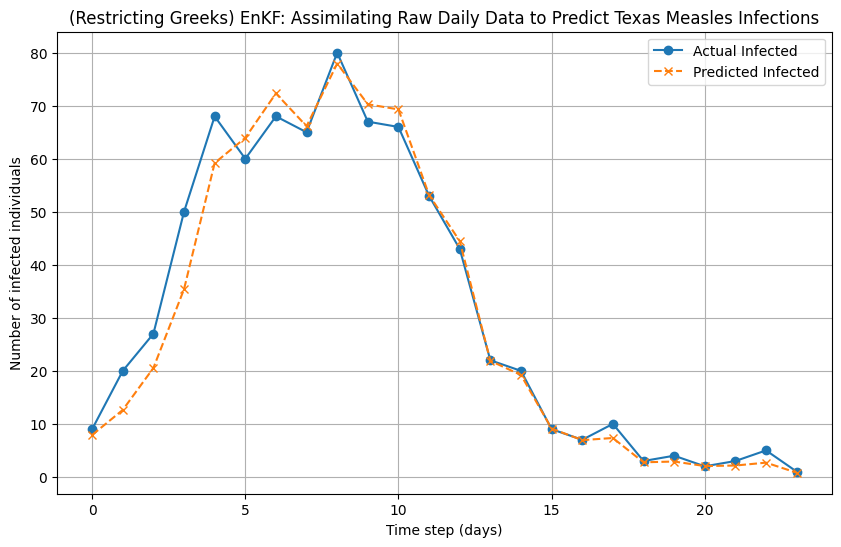

In [232]:
import matplotlib.pyplot as plt

mean_states = results[0]['mean_states']
pred_I = mean_states[:, 1]
actual_I = merged_df['Infected'].values[:len(pred_I)]

plt.figure(figsize=(10, 6))
plt.plot(actual_I, label='Actual Infected', linestyle='-', marker='o')
plt.plot(pred_I, label='Predicted Infected', linestyle='--', marker='x')
plt.xlabel('Time step (days)')
plt.ylabel('Number of infected individuals')
plt.title('(Restricting Greeks) EnKF: Assimilating Raw Daily Data to Predict Texas Measles Infections')
plt.legend()
plt.grid(True)
plt.show()


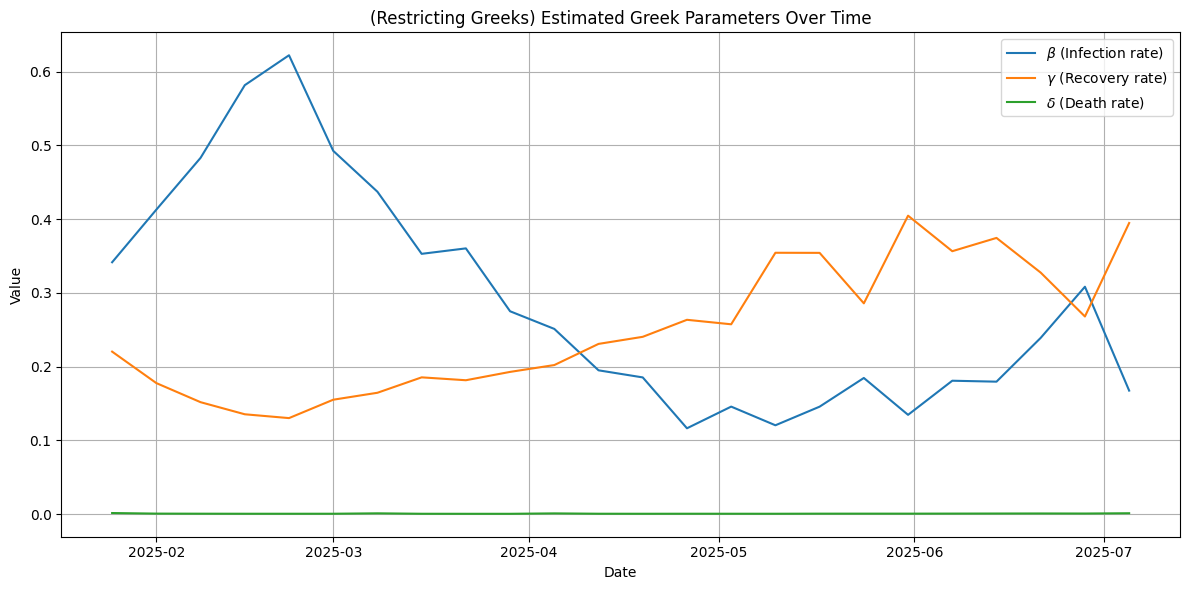

In [233]:
import matplotlib.pyplot as plt

def plot_greek_parameters_over_time(mean_states, dates):
    # mean_states shape is (n_timesteps, 6) with columns [S, I, D, beta, gamma, delta]
    beta = mean_states[:, 3]
    gamma = mean_states[:, 4]
    delta = mean_states[:, 5]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, beta, label=r'$\beta$ (Infection rate)')
    plt.plot(dates, gamma, label=r'$\gamma$ (Recovery rate)')
    plt.plot(dates, delta, label=r'$\delta$ (Death rate)')

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('(Restricting Greeks) Estimated Greek Parameters Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage after your EnKF run for seed 10:
mean_states = results[0]['mean_states']
dates = merged_df['date'][:mean_states.shape[0]]

plot_greek_parameters_over_time(mean_states, dates)


In [234]:
# import pandas as pd

# # After running your EnKF and getting predictions & dates
# dates = merged_df['date'][:len(results[0]['mean_states'])]  # get dates matching mean_states length
# predicted_infected = results[0]['mean_states'][:, 1]        # assuming infected is at idx 1
# true_infected = merged_df['Infected'][:len(predicted_infected)].to_numpy()

# # Create DataFrame
# df_save = pd.DataFrame({
#     'date': dates,
#     'EnKF Infected': predicted_infected,
#     'true_infected': true_infected
# })

# # Save to CSV (use raw string for windows paths)
# csv_path = r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\combined graphs\weekly.csv"
# df_save.to_csv(csv_path, index=False)


# rollover

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

# Assume your existing EnKF helper functions are defined:
# sird_step, enforce_mass, R_from_obs, predict_measurement, enkf_train_then_forecast_single_seed
# Also, merged_df has 'Date', 'Infected', 'Deaths' columns

def run_rolling_forecast(Y_obs, initial_train_end_idx, initial_forecast_horizon, n_ens, seeds):
    dates = merged_df['date'].to_numpy()
    total_len = len(Y_obs)

    train_start_idx = 0
    train_end_idx = initial_train_end_idx
    forecast_horizon = initial_forecast_horizon

    all_forecasts = []

    # Loop until forecast horizon shrinks to zero or you run out of data
    while forecast_horizon > 0 and train_end_idx + forecast_horizon <= total_len - 1:
        # 1. Prepare training data up to train_end_idx
        Y_train = Y_obs[train_start_idx:train_end_idx + 1]

        # 2. Construct features for HMM (raw increments + slope7 + diff7)
        inc = np.diff(Y_train[:, 0], prepend=0)
        slope7 = pd.Series(inc).rolling(window=7, min_periods=1).mean()
        diff7 = pd.Series(inc).diff(7).fillna(0)
        features = np.column_stack([inc, slope7, diff7])
        features = StandardScaler().fit_transform(features)

        # 3. Initialize and train HMM with fixed parameters to avoid reinit warnings
        model_hmm = hmm.GaussianHMM(
            n_components=2,
            covariance_type="full",
            n_iter=100,
            init_params="",  # no internal reinitialization to preserve manual params
            random_state=42,
        )
        model_hmm.startprob_ = np.array([0.5, 0.5])
        model_hmm.transmat_ = np.array([[0.8, 0.2], [0.2, 0.8]])
        model_hmm.means_ = np.array([[-1.0, 0.0, 0.0], [1.0, 0.5, 0.5]])
        model_hmm.covars_ = np.array([np.eye(3), np.eye(3)])
        model_hmm.fit(features)

        # 4. Decode regimes and simulate future states
        logprob, seq_states = model_hmm.decode(features, algorithm='viterbi')
        last_state = seq_states[-1]
        forecast_states = [last_state]
        for _ in range(forecast_horizon - 1):
            forecast_states.append(np.random.choice(2, p=model_hmm.transmat_[forecast_states[-1]]))
        forecast_states = np.array(forecast_states)
        plateau_state = np.argmin(model_hmm.means_[:, 0])

        # 5. Run EnKF forecast on current training+forecast range
        seed_forecasts = []
        for s in seeds:
            _, f_states = enkf_train_then_forecast_single_seed(Y_obs, train_end_idx, forecast_horizon, sim_seed=s)
            seed_forecasts.append(f_states[:, 1])  # infected state index
        mean_forecast = np.mean(np.vstack(seed_forecasts), axis=0)

        # 6. Dampen forecast on plateau regime days
        last_obs_C = Y_obs[train_end_idx, 0]
        for i, st in enumerate(forecast_states):
            if st == plateau_state:
                mean_forecast[i] = last_obs_C + 0.2 * (mean_forecast[i] - last_obs_C)

        # 7. Store forecast and date info
        forecast_dates = pd.date_range(
            start=pd.Timestamp(dates[train_end_idx]) + pd.Timedelta(days=1),
            periods=forecast_horizon,
            freq='D',
        )

        all_forecasts.append({
            'train_end_idx': train_end_idx,
            'forecast_horizon': forecast_horizon,
            'forecast_dates': forecast_dates,
            'forecast_mean': mean_forecast,
            'forecast_states': forecast_states
        })

        # 8. Advance window and shrink horizon
        train_end_idx += 1
        forecast_horizon -= 1

    return all_forecasts

# Example usage:
initial_train_end_idx = np.where(merged_df['date'] >= pd.to_datetime('2025-04-10'))[0][0]
forecast_days = 10
n_ensemble = 500
ensemble_seeds = np.arange(10, 15)

Y_obs = merged_df[['Infected', 'Deaths']].to_numpy()

rolling_results = run_rolling_forecast(Y_obs, initial_train_end_idx, forecast_days, n_ensemble, ensemble_seeds)

# Plot only once per forecast iteration, no over 100 plots
for res in rolling_results:
    plt.figure(figsize=(10, 5))
    
    # Plot forecasted infected
    plt.plot(res['forecast_dates'], res['forecast_mean'], label='Forecasted Infected')
    
    # Plot true infected for same forecast dates (safely handling missing data)
    true_vals = merged_df.set_index('date').reindex(res['forecast_dates'])['Infected']
    plt.plot(res['forecast_dates'], true_vals, 'k-', label='True Infected')
    
    # Plot regime states as colored scatter points
    plateau_days = res['forecast_dates'][res['forecast_states'] == 0]
    growth_days = res['forecast_dates'][res['forecast_states'] == 1]
    plt.scatter(plateau_days, res['forecast_mean'][res['forecast_states'] == 0], color='red', label='Plateau regime')
    plt.scatter(growth_days, res['forecast_mean'][res['forecast_states'] == 1], color='green', label='Growth regime')
    
    plt.title(f"Forecast Starting from {res['forecast_dates'][0].date()} "
              f"(train index {res['train_end_idx']}, forecast horizon {res['forecast_horizon']})")
    plt.xlabel('Date')
    plt.ylabel('Infected (mean forecast)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


NameError: name 'enkf_train_then_forecast_single_seed' is not defined

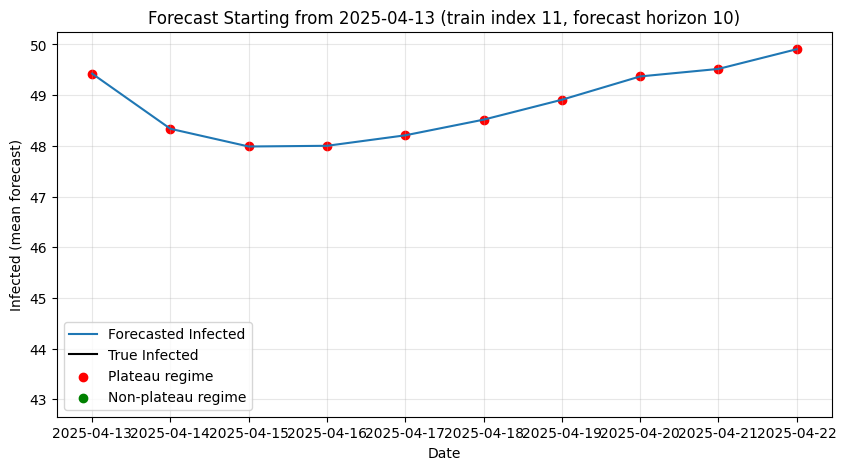

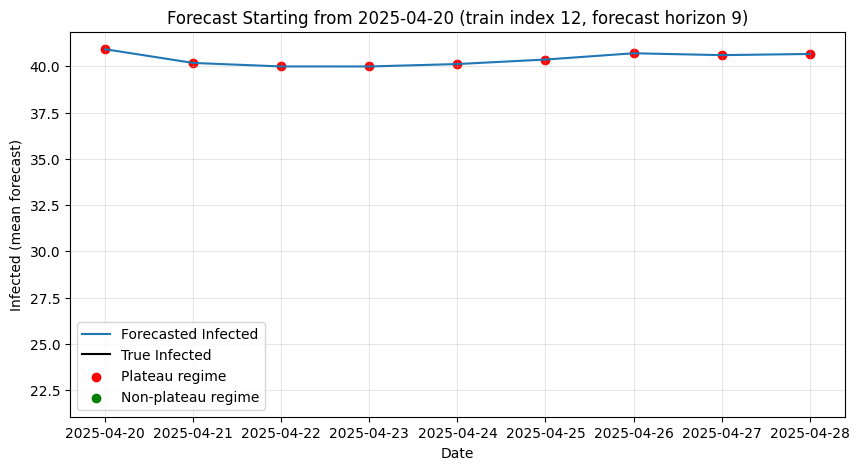

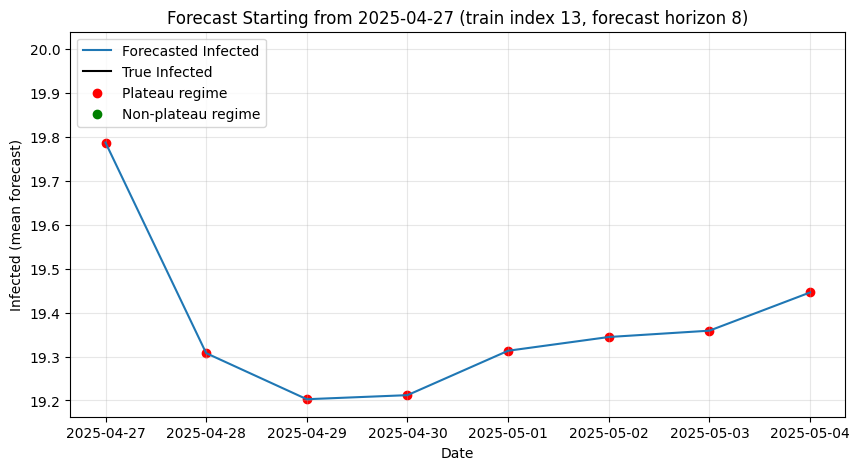

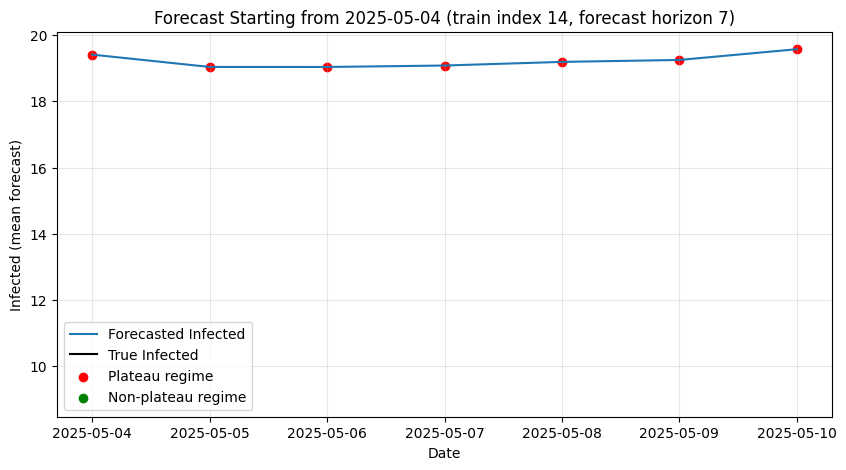

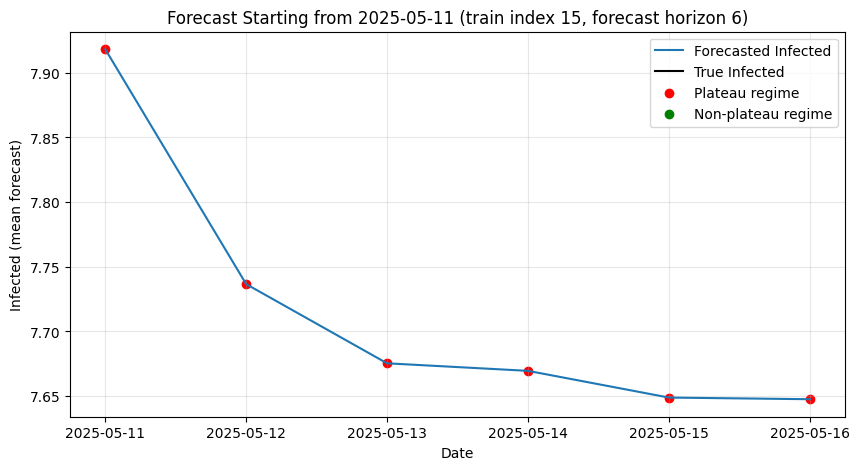

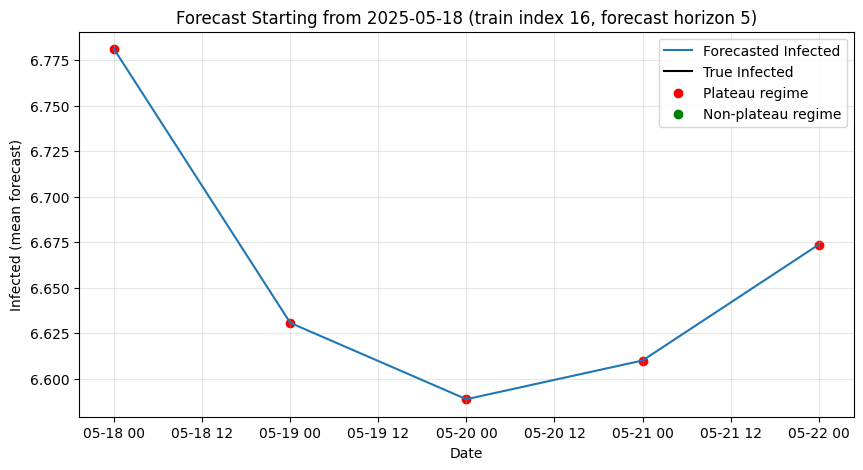

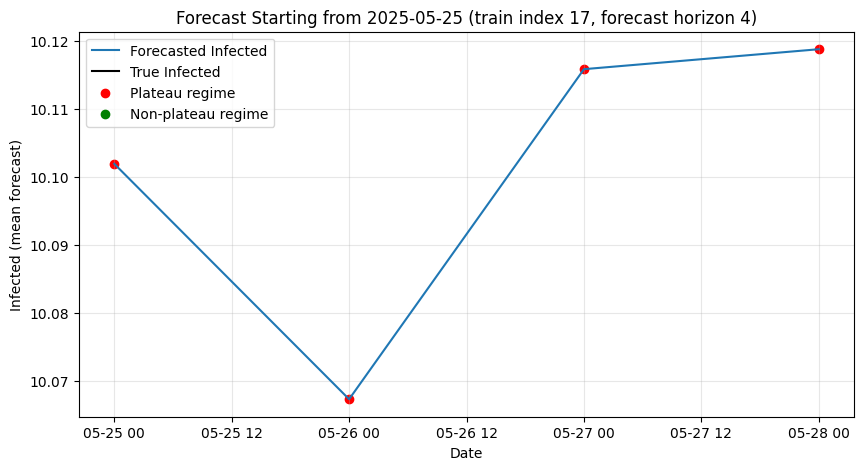

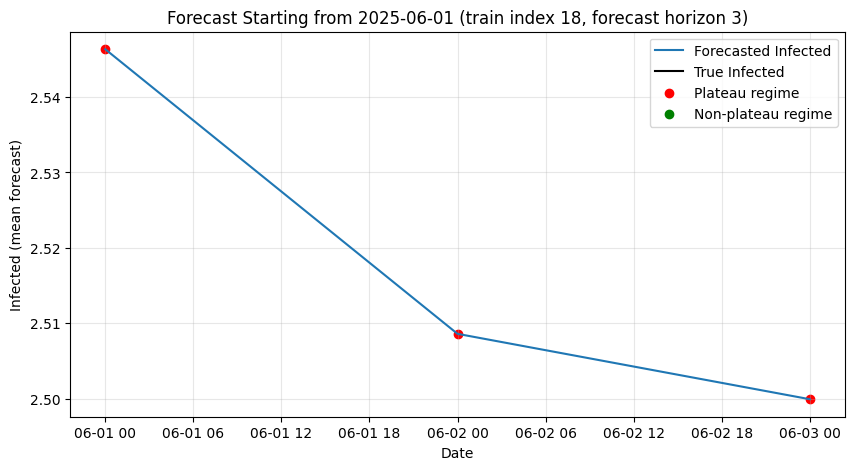

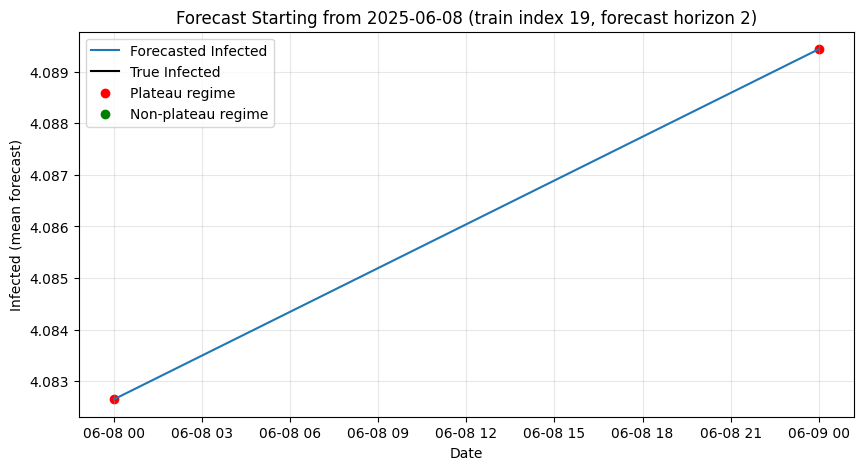

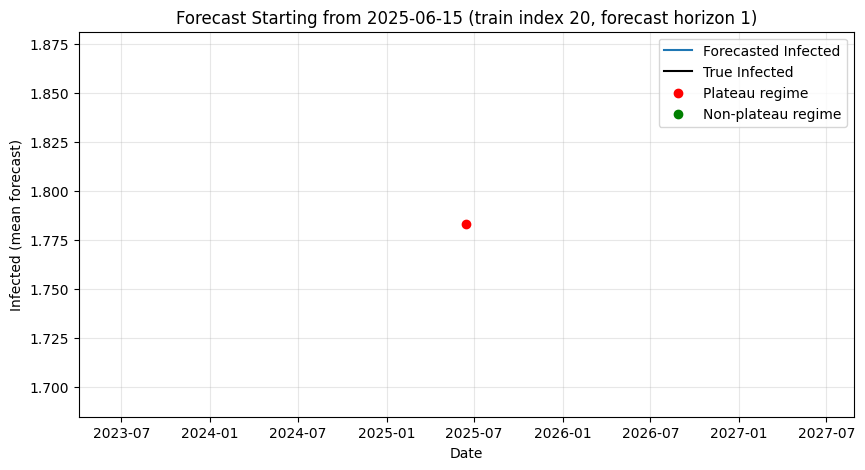

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

# --- Your existing helper functions required: sird_step, enforce_mass, R_from_obs, predict_measurement

def enkf_train_then_forecast_single_seed(Y_obs, cap_idx, horizon, sim_seed):
    rng = np.random.default_rng(sim_seed)

    # Initialize ensemble from priors for [S, I, D, beta, gamma, delta]
    state_ens = np.zeros((n_ens, 6))
    for i in range(n_ens):
        perturb = 1 + ens_perturb * rng.normal(size=2)
        ID = np.maximum(x0_mean[1:] * perturb, 0)
        S = max(N - ID.sum(), 0)
        beta = rng.uniform(beta_low, beta_high)
        gamma = rng.uniform(gamma_low, gamma_high)
        delta = rng.uniform(delta_low, delta_high)
        state_ens[i] = np.array([S, ID[0], ID[1], beta, gamma, delta])

    ensemble_states_hist = np.full((cap_idx + 1, n_ens, 6), np.nan)

    # Assimilate observed data up to cap_idx
    for k in range(cap_idx + 1):
        for i in range(n_ens):
            state_ens[i] = sird_step(state_ens[i], N, k, dt)

        state_ens = enforce_mass(state_ens, N)
        ensemble_states_hist[k] = state_ens.copy()

        meas_pred = predict_measurement(state_ens)  # shape (n_ens, 2) for [I,D]
        y_obs_k = Y_obs[k]
        y_obs_k = np.nan_to_num(y_obs_k, nan=1e-2)
        Rk = R_from_obs(y_obs_k)
        obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

        aug_ens = state_ens.copy()
        aug_mean = np.mean(aug_ens, axis=0)
        meas_mean = np.mean(meas_pred, axis=0)

        X = aug_ens - aug_mean
        Y = meas_pred - meas_mean
        Cxy = (X.T @ Y) / (n_ens - 1)
        Cyy = (Y.T @ Y) / (n_ens - 1)

        K = Cxy @ np.linalg.inv(Cyy + Rk)

        for i in range(n_ens):
            innovation = obs_perturbed[i] - meas_pred[i]
            state_ens[i] = aug_ens[i] + alpha * (K @ innovation)

        state_ens = enforce_mass(state_ens, N)

    # Forecast horizon without assimilation
    forecast_states_hist = np.full((horizon, n_ens, 6), np.nan)
    last_obs_idx = cap_idx
    for h in range(horizon):
        for i in range(n_ens):
            state_ens[i] = sird_step(state_ens[i], N, last_obs_idx + h, dt)
        state_ens = enforce_mass(state_ens, N)
        forecast_states_hist[h] = state_ens.copy()

    train_mean_states = np.nanmean(ensemble_states_hist, axis=1)
    forecast_mean_states = np.nanmean(forecast_states_hist, axis=1)

    return train_mean_states, forecast_mean_states


def run_rolling_forecast(Y_obs, initial_train_end_idx, initial_forecast_horizon, n_ens, seeds):
    dates = merged_df['date'].to_numpy()
    total_len = len(Y_obs)

    train_start_idx = 0
    train_end_idx = initial_train_end_idx
    forecast_horizon = initial_forecast_horizon

    all_forecasts = []

    while forecast_horizon > 0 and train_end_idx + forecast_horizon <= total_len - 1:
        Y_train = Y_obs[train_start_idx:train_end_idx + 1]

        # Features for HMM from raw daily increments (non-cumulative)
        inc = np.diff(Y_train[:, 0], prepend=0)
        slope7 = pd.Series(inc).rolling(window=7, min_periods=1).mean()
        diff7 = pd.Series(inc).diff(7).fillna(0)
        features = np.column_stack([inc, slope7, diff7])
        features = StandardScaler().fit_transform(features)

        # 2-state HMM: 0 = plateau (lowest mean), 1 = non-plateau
        model_hmm = hmm.GaussianHMM(
            n_components=2,
            covariance_type="full",
            n_iter=100,
            init_params="",  # preserve manual params
            random_state=42,
        )
        model_hmm.startprob_ = np.array([0.5, 0.5])
        model_hmm.transmat_ = np.array([[0.8, 0.2], [0.2, 0.8]])

        # Means: plateau = lower mean, non-plateau = higher mean
        model_hmm.means_ = np.array([[-1.0, 0.0, 0.0], [0.5, 0.5, 0.5]])
        model_hmm.covars_ = np.array([np.eye(3), np.eye(3)])

        model_hmm.fit(features)

        logprob, seq_states = model_hmm.decode(features, algorithm='viterbi')
        last_state = seq_states[-1]
        forecast_states = [last_state]
        for _ in range(forecast_horizon - 1):
            forecast_states.append(np.random.choice(2, p=model_hmm.transmat_[forecast_states[-1]]))
        forecast_states = np.array(forecast_states)

        plateau_state = np.argmin(model_hmm.means_[:, 0])

        seed_forecasts = []
        for s in seeds:
            _, f_states = enkf_train_then_forecast_single_seed(Y_obs, train_end_idx, forecast_horizon, sim_seed=s)
            seed_forecasts.append(f_states[:, 1])  # infected idx
        mean_forecast = np.mean(np.vstack(seed_forecasts), axis=0)

        last_obs_C = Y_obs[train_end_idx, 0]
        for i, st in enumerate(forecast_states):
            if st == plateau_state:
                mean_forecast[i] = last_obs_C + 0.2 * (mean_forecast[i] - last_obs_C)

        forecast_dates = pd.date_range(
            start=pd.Timestamp(dates[train_end_idx]) + pd.Timedelta(days=1),
            periods=forecast_horizon,
            freq='D',
        )

        all_forecasts.append({
            'train_end_idx': train_end_idx,
            'forecast_horizon': forecast_horizon,
            'forecast_dates': forecast_dates,
            'forecast_mean': mean_forecast,
            'forecast_states': forecast_states,
        })

        train_end_idx += 1
        forecast_horizon -= 1

    return all_forecasts


# Example usage
initial_train_end_idx = np.where(merged_df['date'] >= pd.to_datetime('2025-04-10'))[0][0]
forecast_days = 10
n_ensemble = 500
ensemble_seeds = np.arange(10, 15)

Y_obs = merged_df[['Infected', 'Deaths']].to_numpy()

rolling_results = run_rolling_forecast(Y_obs, initial_train_end_idx, forecast_days, n_ensemble, ensemble_seeds)

for res in rolling_results:
    plt.figure(figsize=(10, 5))
    plt.plot(res['forecast_dates'], res['forecast_mean'], label='Forecasted Infected')
    true_vals = merged_df.set_index('date').reindex(res['forecast_dates'])['Infected']
    plt.plot(res['forecast_dates'], true_vals, 'k-', label='True Infected')

    plateau_days = res['forecast_dates'][res['forecast_states'] == 0]
    non_plateau_days = res['forecast_dates'][res['forecast_states'] == 1]
    plt.scatter(plateau_days, res['forecast_mean'][res['forecast_states'] == 0], color='red', label='Plateau regime')
    plt.scatter(non_plateau_days, res['forecast_mean'][res['forecast_states'] == 1], color='green', label='Non-plateau regime')

    plt.title(f"Forecast Starting from {res['forecast_dates'][0].date()} "
              f"(train index {res['train_end_idx']}, forecast horizon {res['forecast_horizon']})")
    plt.xlabel('Date')
    plt.ylabel('Infected (mean forecast)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
